In [14]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import train_test_split

from collections import defaultdict

In [ ]:
import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")

In [ ]:
reviews = pd.read_csv('../data/all_reviews.csv',sep='\t',encoding='utf-8', index_col=0)
users = pd.read_csv('../data/all_users.csv',sep='\t',encoding='utf-8', index_col=0)
reviews.animation = reviews.animation.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.character = reviews.character.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.overall = reviews.overall.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.sound = reviews.sound.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.story = reviews.story.str.strip().str[0:-3].convert_objects(convert_numeric=True)

### Cleaning user information

In [ ]:
for i in users.index:
    temp = users.ix[i,'age_sex'].strip().split('/')
    age = '?'
    sex = '?'
    if len(temp)==2:
        age = temp[0]
        sex = temp[1]
    elif temp[0].isdigit():
        age = temp[0]
    else:
        sex = temp[0]
    users.ix[i,'age']=age
    users.ix[i,'sex']=sex

In [ ]:
subusers = users.loc[(users.age!='? ')&(users.sex!='?')]
print subusers.shape
subusers.head()

### Combining users with review information

In [ ]:
mask = [ True if i in subusers.index.tolist() else False for i in reviews.name]
subreviews = reviews.loc[mask]

In [ ]:
age = []
sex = []

for i in subreviews.index:
    age.append(int(subusers.ix[subreviews.ix[i,'name'],'age']))
    sex.append(subusers.ix[subreviews.ix[i,'name'],'sex'])
    
subreviews.loc[:,'age']=age
subreviews.loc[:,'sex']=sex

subreviews.head()

In [ ]:
subusers.head()

In [ ]:
mean_age = subreviews.age.mean()

age = []
sex = []

final = reviews.copy()

for i in final.index:
    name = final.ix[i,'name']
    if name in subusers.index:
        age.append(int(subusers.ix[name,'age']))
        sex.append(subusers.ix[name,'sex'])
    else:
        age.append(mean_age)
        ran = np.random.random_integers(0,high=1)
        if ran==1:
            sex.append('M')
        else:
            sex.append('F')
        
    
final.loc[:,'age']=age
final.loc[:,'sex']=sex

final.head()

In [ ]:
for i,val in enumerate(final.anime_name):
    if val == 'Beyblade: G Revolution':
        final.ix[i,'anime_name']='Beyblade G Revolution'
    if val == 'Beyblade: V-Force':
        final.ix[i,'anime_name']='Beyblade V-Force'
    if val == 'Beyblade: The Movie':
        final.ix[i,'anime_name']='Beyblade - The Movie'

### Adding in more features

In [ ]:
data=pd.read_csv("../data/anime_info.csv",sep='\t', index_col=0)
anime_name = pd.read_csv('../data/anime_name.csv',sep='\t',encoding='utf-8', index_col=0)
data.head()

In [ ]:
names = []
for i in data.index:
    names.append(i.encode('ascii', 'ignore'))
data.index=names

In [ ]:
# checking how many unique categories
genres = data.categories.tolist()

temp = []
for i in genres:
    if type(i)==str:
        temp+=i.replace('[','').replace(']','').replace(' ','').split(',')
uniq_genres = list(set(temp))
len(uniq_genres)

In [ ]:
# changing categories from string to list
temp = []
genres = data.categories.tolist()
for i in genres:
    if type(i)==str:
        temp.append(i.replace('[','').replace(']','').replace(' ','').split(','))
    else:
        temp.append([])
data.loc[:,'categories_list'] = temp

In [ ]:
# finding categories
categories = defaultdict(list)
for i in final.anime_name:
    cat = data.loc[i.encode('ascii', 'ignore'),'categories_list']
    for j in cat:
        categories[j].append(1)
    for k in uniq_genres:
        if k not in cat:
            categories[k].append(0)
            
# add categories to final
for i in categories:
    final.loc[:,i] = categories[i]

In [ ]:
per = final.shape[0]*0.005
print (final.ix[:,11:].sum(axis=0)>per).sum()
mask = (final.ix[:,11:].sum(axis=0)>per)

In [ ]:
for i in final.columns[11:]:
    check = mask[i]
    if not check:
        final.drop(i,axis=1,inplace=True)

In [ ]:
final.to_csv('../data/final_review.csv')

### Data

In [6]:
final = pd.read_csv('../data/final_review.csv',index_col=0)

In [3]:
ratings = ['animation','character','overall','sound','story']
for i in ratings:
    mean = final.ix[:,i].mean()
    final.ix[:,i].fillna(mean,inplace=True)

In [4]:
# in case of repeats
print final.shape
final=final.drop_duplicates(['anime','name'])
print final.shape

(17194, 142)
(17194, 142)


User review counts mean and median 3.85342895563 1.0


(0, 20)

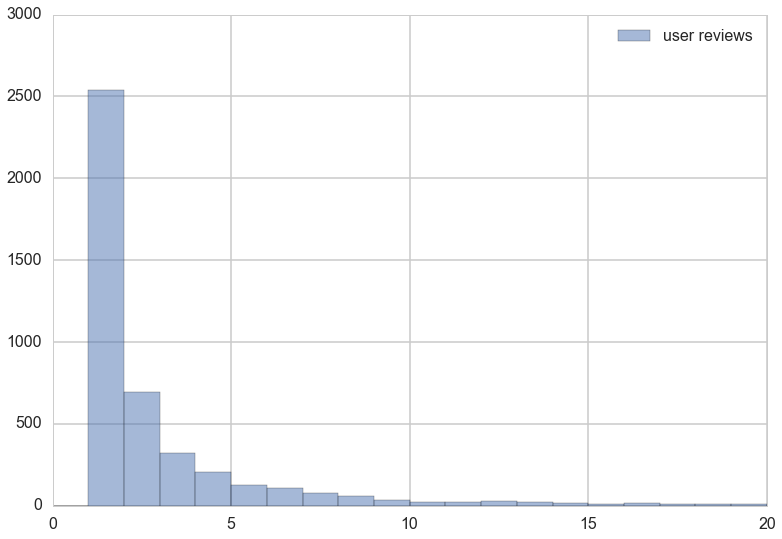

In [13]:
c=final.groupby('name').anime.count()
print "User review counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(50), alpha=0.5, label="user reviews");
plt.legend();
plt.xlim([0,20])

In [43]:
# sort animes with more than one review
# anime_vc = final.anime.value_counts()
# sub_reviews = final[final.anime.isin(anime_vc[anime_vc > 10].index)]

# splitting into train, test, and validate
train, test = train_test_split(final,train_size=0.5,test_size=0.5)
validate, test = train_test_split(test,train_size=0.5,test_size=0.5)

In [44]:
train.shape,test.shape

((8597, 141), (4299, 141))

In [45]:
ybar = train.overall.mean()
ybar

7.152989414912215

In [46]:
# mapping of userid and anime
uuids=train.name.unique()#unique-user-ids
uiids=train.anime.unique()#unique-item-ids

uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

In [47]:
user_biases = dict()
for i,val in final.groupby('name'):
    user_biases[i] = np.mean(val.overall)-ybar

anime_biases = dict()
for i,val in final.groupby('anime'):
    anime_biases[i] = np.mean(val.overall)-ybar

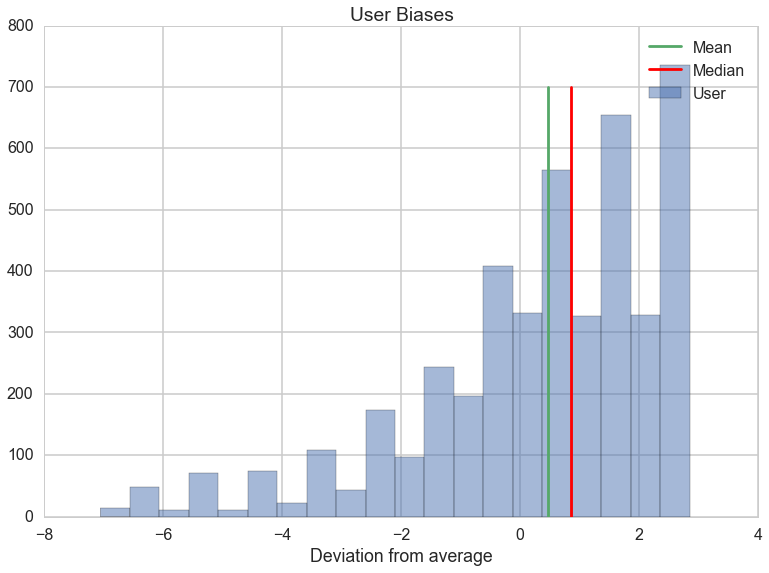

In [48]:
hist1 = plt.hist(user_biases.values(),alpha=0.5,bins=20,label='User')
plt.title('User Biases')
plt.xlabel("Deviation from average")
plt.plot([np.mean(user_biases.values()),np.mean(user_biases.values())],[0,700],label='Mean')
plt.plot([np.median(user_biases.values()),np.median(user_biases.values())],[0,700],color='r',label='Median')
plt.legend()

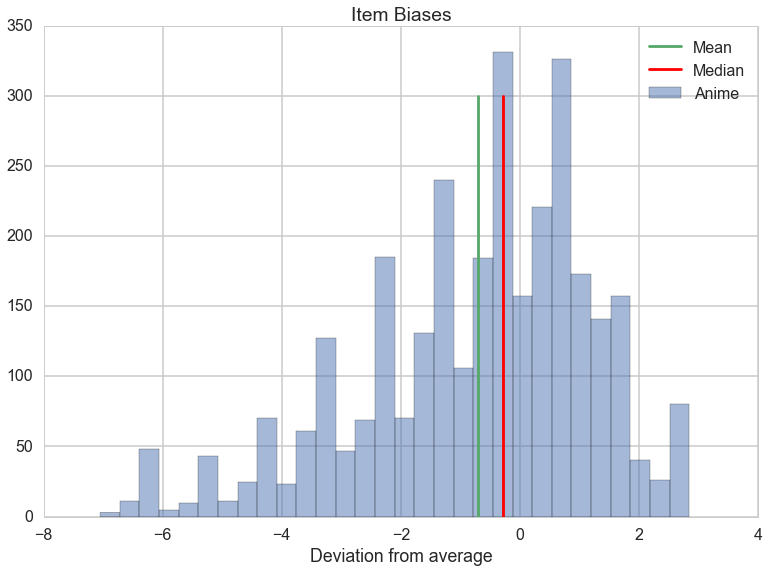

In [49]:
hist2 = plt.hist(anime_biases.values(),bins=30,alpha=0.5,label='Anime')
plt.title('Item Biases')
plt.xlabel("Deviation from average")
plt.plot([np.mean(anime_biases.values()),np.mean(anime_biases.values())],[0,300],label='Mean')
plt.plot([np.median(anime_biases.values()),np.median(anime_biases.values())],[0,300],color='r',label='Median')
plt.legend()

In [50]:
train_avgs={'mean':ybar, 'users':user_biases, 'animes':anime_biases}
predictions={}
predictions_valid={}

In [66]:
# saving user and anime biases in train and validate sets
predictions["baseline"] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime] for i in test.iterrows()]
predictions_valid['baseline'] = [ybar+user_biases[i[1][4]]+anime_biases[i[1].anime] for i in validate.iterrows()]

In [74]:
def get_rmse(s, s_predict):
    diff = np.subtract(s,s_predict)
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [79]:
def compare_results(stars_actual, stars_predicted, ylow=0, yhigh=10, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,10],[0,10], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0, 10])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 1.58588289529


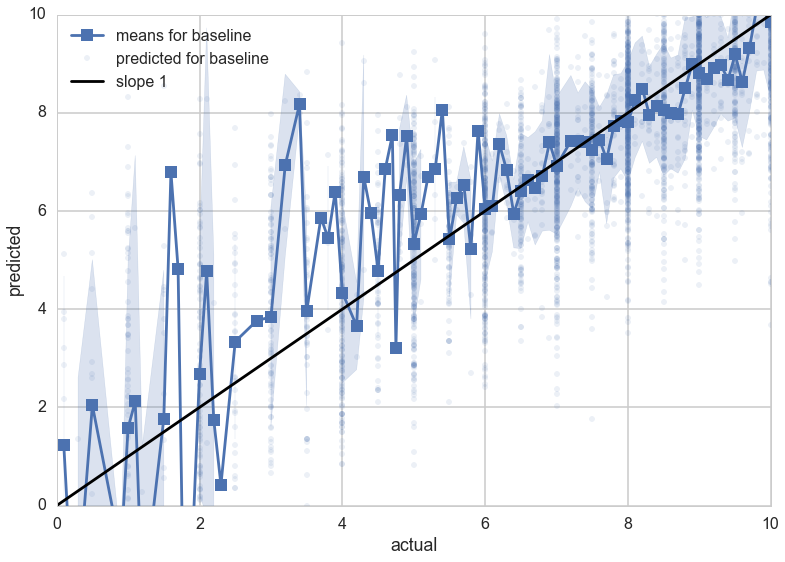

In [80]:
compare_results(test.overall.tolist(),predictions['baseline'], model="baseline", predicteds=True);

In [73]:
predictions['baseline']

[10.773933662010862,
 7.625388963466164,
 7.471006850260522,
 9.18034391842112,
 8.14167306546455,
 8.769232807310008,
 8.077779815857017,
 9.785245879205432,
 7.810366419224718,
 10.409510585087785,
 9.347010585087785,
 6.847010585087785,
 10.547010585087785,
 6.758895830989425,
 6.4347298833334,
 10.764657643911315,
 10.195495433572633,
 10.271334909412111,
 7.470820108897308,
 9.647010585087786,
 10.395946755300551,
 7.082724870802071,
 7.354261667338868,
 6.7898335515949615,
 3.8279629660401664,
 10.281625969703171,
 7.900582013659214,
 4.9227681608453615,
 8.359131797208995,
 10.547010585087785,
 9.374283312360513,
 7.8223047027348445,
 7.369010585087787,
 7.3015560396332395,
 5.42094997902718,
 2.2970105850877856,
 5.739027391810476,
 3.801814078537566,
 6.622010585087786,
 5.019351010619701,
 8.2760428431523,
 8.447450467785735,
 10.093677251754452,
 7.637516914201709,
 9.0628836009608,
 8.066510585087784,
 8.369406731987244,
 8.263677251754451,
 6.847010585087785,
 8.3470105850